## ETM

In [1]:
import torch
import torch.nn.functional as F 
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ETM(nn.Module):
    def __init__(self, num_topics, vocab_size, t_hidden_size, rho_size,
                    theta_act, embeddings=None, train_embeddings=True, enc_drop=0.5):
        super(ETM, self).__init__()

        # define hyperparameters
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.t_hidden_size = t_hidden_size
        self.rho_size = rho_size
        self.enc_drop = enc_drop
        self.t_drop = nn.Dropout(enc_drop)

        self.theta_act = self.get_activation(theta_act)

        self.train_embeddings = train_embeddings        
        
        # define the word embedding matrix \rho
        if self.train_embeddings:
            self.rho = nn.Parameter(torch.randn(vocab_size, rho_size)) # V x L
        else:
            self.rho = embeddings.clone().float().to(device) # V x L

        # define the matrix containing the topic embeddings
        self.alphas = nn.Linear(rho_size, num_topics, bias=False)#nn.Parameter(torch.randn(rho_size, num_topics))
    
        # define variational distribution for \theta_{1:D} via amortizartion
        self.q_theta = nn.Sequential(
                nn.Linear(vocab_size, t_hidden_size), 
                self.theta_act,
                nn.Linear(t_hidden_size, t_hidden_size),
                self.theta_act,
            )
        self.mu_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)

    def get_activation(self, act):
        if act == 'tanh':
            act = nn.Tanh()
        elif act == 'relu':
            act = nn.ReLU()
        elif act == 'softplus':
            act = nn.Softplus()
        elif act == 'rrelu':
            act = nn.RReLU()
        elif act == 'leakyrelu':
            act = nn.LeakyReLU()
        elif act == 'elu':
            act = nn.ELU()
        elif act == 'selu':
            act = nn.SELU()
        elif act == 'glu':
            act = nn.GLU()
        else:
            print('Defaulting to tanh activations...')
            act = nn.Tanh()
        return act 

    # theta ~ mu + std N(0,1)
    def reparameterize(self, mu, logvar):
        """Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar) 
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def encode(self, bows):
        """Returns paramters of the variational distribution for \theta.

        input: bows
                batch of bag-of-words...tensor of shape bsz x V
        output: mu_theta, log_sigma_theta
        """
        q_theta = self.q_theta(bows)
        if self.enc_drop > 0:
            q_theta = self.t_drop(q_theta)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)

        # KL[q(theta)||p(theta)] = lnq(theta) - lnp(theta)
        kl_theta = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()
        return mu_theta, logsigma_theta, kl_theta

    def get_beta(self):
        ## softmax over vocab dimension
        beta = F.softmax(self.alphas(self.rho), dim=0).transpose(1, 0)
        return beta

    def get_theta(self, normalized_bows):
        mu_theta, logsigma_theta, kld_theta = self.encode(normalized_bows)
        z = self.reparameterize(mu_theta, logsigma_theta)
        theta = F.softmax(z, dim=-1) 
        return theta, kld_theta

    def decode(self, theta, beta):
        res = torch.mm(theta, beta)
        preds = torch.log(res+1e-6)
        return preds 

    def forward(self, X, X_normalized, theta=None, aggregate=True):
        ## get \theta
        if theta is None:
            theta, kld_theta = self.get_theta(X_normalized)
        else:
            kld_theta = None

        ## get \beta
        beta = self.get_beta()

        ## get prediction loss
        preds = self.decode(theta, beta)
        recon_loss = -(preds * X).sum(1)
        if aggregate:
            recon_loss = recon_loss.mean()
        return recon_loss, kld_theta

## Import Statement

In [2]:
# STUDENT NAME: Sagar Nandeshwar
# STUDENT ID: 260920948
import pickle
import numpy as np
import pandas as pd

import scanpy as sc
import anndata
import random

import torch
#from etm import ETM
from torch import optim
from torch.nn import functional as F

import os
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from seaborn import heatmap, lineplot, clustermap

## Loading data

In [3]:
random.seed(10)
# mouse pancreas single-cell dataset
# read in data and cell type labels
with open('data/MP.pickle', 'rb') as f:
    df = pickle.load(f)

with open('data/MP_genes.pickle', 'rb') as f:
    genes = pickle.load(f)

df.set_index('Unnamed: 0', inplace=True)  # set first column (cell ID as the index column)
sample_id = pickle.load(open('data/cell_IDs.pkl', 'rb'))
df = df.loc[list(sample_id), :]

X = df[genes].values  # extract the N x M cells-by-genes matrix

sample_info = pd.read_csv('data/sample_info.csv')

mp_anndata = anndata.AnnData(X=X)

mp_anndata.obs['Celltype'] = sample_info['assigned_cluster'].values

N = X.shape[0]  # number of single-cell samples
K = 16  # number of topics
M = X.shape[1]  # number of genes

## Helper Methods

In [4]:
def evaluate_ari(cell_embed, adata):
    """
        This function is used to evaluate ARI using the lower-dimensional embedding
        cell_embed of the single-cell data
        :param cell_embed: a NxK single-cell embedding generated from NMF or scETM
        :param adata: single-cell AnnData data object (default to to mp_anndata)
        :return: ARI score of the clustering results produced by Louvain
    """
    adata.obsm['cell_embed'] = cell_embed
    sc.pp.neighbors(adata, use_rep="cell_embed", n_neighbors=30)
    sc.tl.louvain(adata, resolution=0.15)
    ari = adjusted_rand_score(adata.obs['Celltype'], adata.obs['louvain'])
    return ari

## Question 1

In [5]:
# Q1 NMF sum of squared error
W_init = np.random.random((M, K))
H_init = np.random.random((K, N))


# Complete this function
def nmf_sse(X, W, H, adata=mp_anndata, niter=100):
    """
        NMF with sum of squared error loss as the objective
        :param X: M x N input matrix
        :param W: M x K basis matrix
        :param H: K x N coefficient matrix
        :param adata: annotated X matrix with cluster labels for evaluating ARI (default to mouse pancreas data)
        :param niter: number of iterations to run
        :return:
            1. updated W and H that minimize sum of squared error ||X - WH||^2_F s.t. W,H>=0
            2. niter-by-3 ndarray with iteration index, SSE, and ARI as the 3 columns
    """
    perf = np.ndarray(shape=(niter, 3), dtype='float')

    # WRITE YOUR CODE HERE
    m, n = X.shape
    cur_W = W
    cur_H = H
    for n in range(niter):
        learning_rate_h = cal_learning_rate_h(X, cur_W, cur_H)
        learning_rate_w = cal_learning_rate_w(X, cur_W, cur_H)
        
        next_H = cur_H + learning_rate_h * d_gradiant_h(X, cur_W, cur_H)
        next_W = cur_W + learning_rate_w * d_gradiant_w(X, cur_W, cur_H)
        
        ari = evaluate_ari(cur_H.T, adata)
        mse = cal_mse(X, cur_W, cur_H) / (m * n)
        
        perf[n] = [n, mse, ari]
        cur_H = next_H
        cur_W = next_W
        
    W = cur_W
    H = cur_H
    return W, H, perf


def cal_mse(X, W, H):
    a = np.matmul(X.T, X)
    a = np.trace(a)
    
    b = np.matmul(X.T, W)
    b = np.matmul(b, H)
    b = np.trace(b)
    
    c = np.matmul(H.T, W.T)
    c = np.matmul(c, X)
    c = np.trace(c)
    
    d = np.matmul(H.T, W.T)
    d = np.matmul(d, W)
    d = np.matmul(d, H)
    d = np.trace(d)
    
    return a - b - c + d


def cal_learning_rate_h(X ,W, H):
    a = H
    b = np.matmul(W.T, W)
    b = np.matmul(b, H)
    return np.divide(a, b)


def cal_learning_rate_w(X ,W, H):
    a = W
    b = np.matmul(W, H)
    b = np.matmul(b, H.T)
    return np.divide(a, b)


def d_gradiant_h(X, W, H):
    a = np.matmul(W.T,X)
    b = np.matmul(W.T, W)
    b = np.matmul(b, H)
    return a - b


def d_gradiant_w(X, W, H):
    a = np.dot(X, H.T)
    b = np.matmul(W, H)
    b = np.matmul(b, H.T)
    return a - b


W_nmf_sse, H_nmf_sse, nmf_sse_perf = nmf_sse(X.T, W_init, H_init, niter=100)

/var/folders/x4/8fjj83rx5hd3kmp8042m26840000gn/T/ipykernel_43784/4144238844.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  mse = cal_mse(X, cur_W, cur_H) / (m * n)


## Question 2

In [6]:
# Q2: write a function to monitor ARI and objective function
def monitor_perf(perf, objective, path=""):
    """
    :param perf: niter-by-3 ndarray with iteration index, objective function, and ARI as the 3 columns
    :param objective: 'SSE', 'Poisson', or 'NELBO'
    :param path: path to save the figure if not display to the screen
    :behaviour: display or save a 2-by-1 plot showing the progress of optimizing objective and ARI as
        a function of iterations
    """
    # WRITE YOUR CODE HERE
    if objective == "ARI":
        x_axis = []
        y_axis = []
        for element in perf:
            x_axis.append(element[0])
            y_axis.append(element[2])
        plt.figure(dpi=160)
        plt.plot(x_axis, y_axis)
        plt.xlabel("Iter")
        plt.ylabel("ARI")
        plt.savefig(path)
        return
    elif objective == "MSE":
        x_axis = []
        y_axis = []
        for element in perf:
            x_axis.append(element[0])
            y_axis.append(element[1])
        plt.figure(dpi=160)
        plt.plot(x_axis, y_axis)
        plt.xlabel("Iter")
        plt.ylabel("MSE")
        plt.savefig(path)
        return
    elif objective == "Poisson":
        x_axis = []
        y_axis = []
        for element in perf:
            x_axis.append(element[0])
            y_axis.append(element[1])
        plt.figure(dpi=160)
        plt.plot(x_axis, y_axis)
        plt.xlabel("Iter")
        plt.ylabel("Poisson")
        plt.savefig(path)
        return
    elif objective == "NELBO":
        x_axis = []
        y_axis = []
        for element in perf:
            x_axis.append(element[0])
            y_axis.append(element[1])
        plt.figure(dpi=160)
        plt.plot(x_axis, y_axis)
        plt.xlabel("Iter")
        plt.ylabel("NELBO")
        plt.savefig(path)
        return
    else:
        print("ERROR")

## Question 1 plots

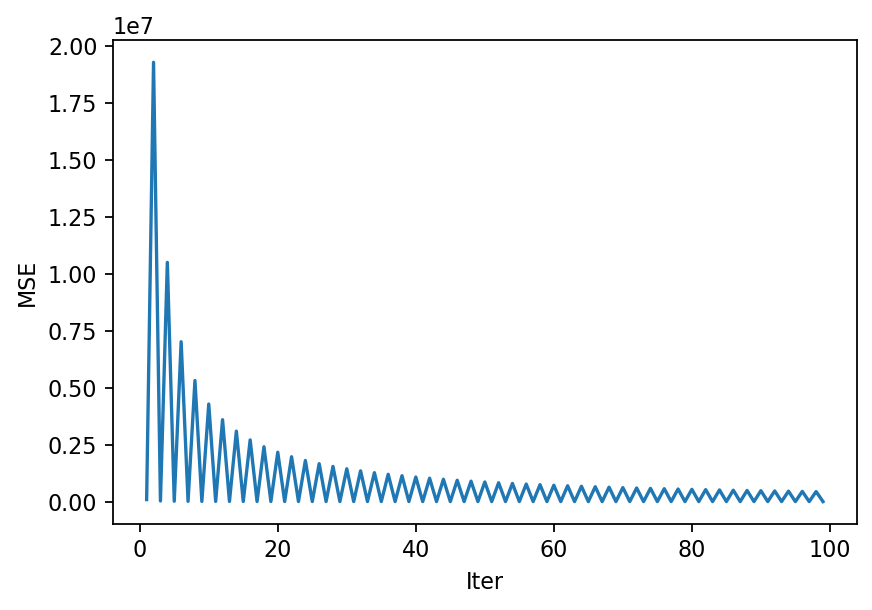

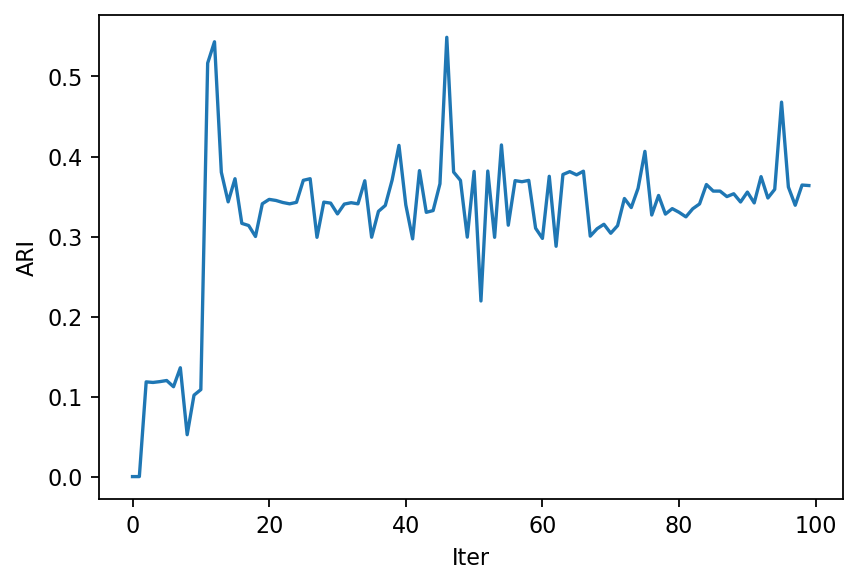

In [7]:
monitor_perf(nmf_sse_perf, "MSE", 'figures/nmf_sse.eps')
monitor_perf(nmf_sse_perf, "ARI", 'figures/nmf_ari.eps')

## Question 2

0


/var/folders/x4/8fjj83rx5hd3kmp8042m26840000gn/T/ipykernel_43784/1396655159.py:37: RuntimeWarning: divide by zero encountered in true_divide
  mse = cal_log(X, cur_W, cur_H) / (m * n)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


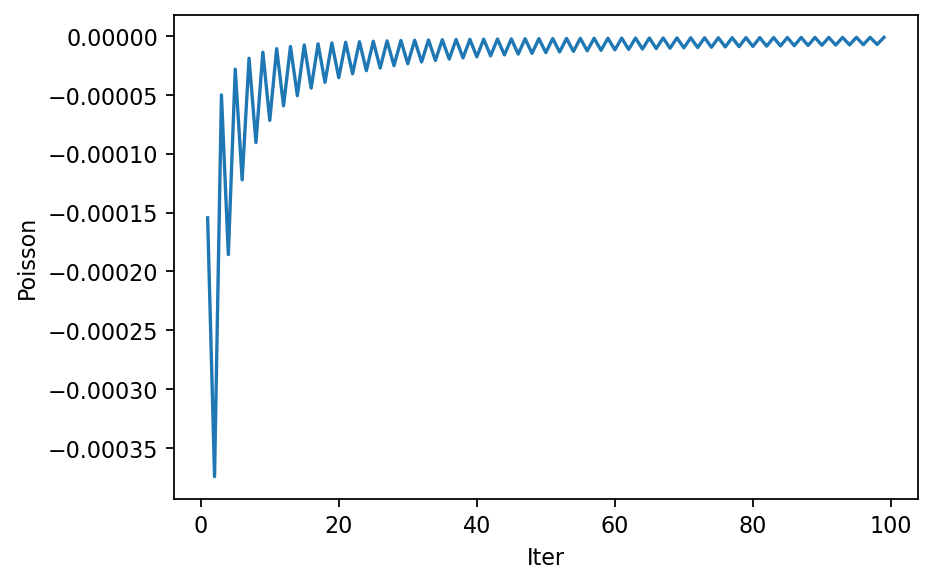

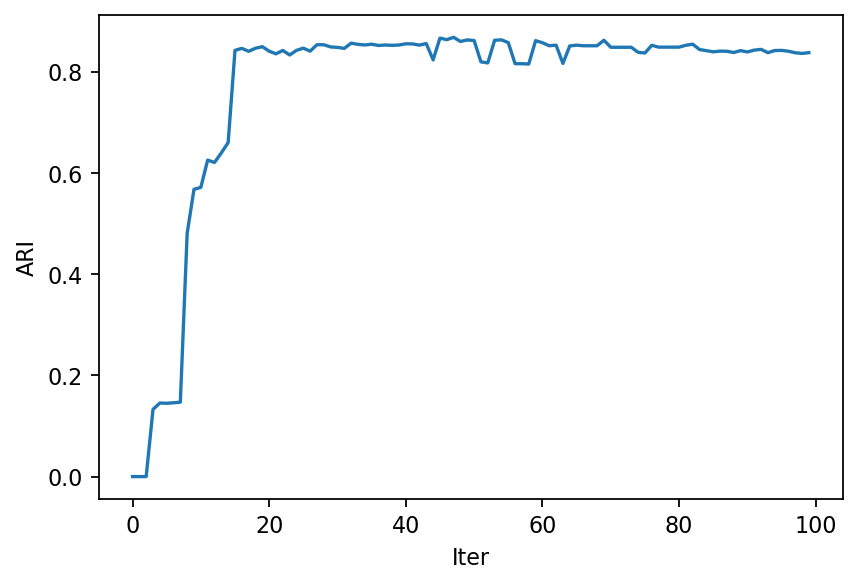

In [8]:
######## Q3 NMF Poisson likelihood ########
# NMF with Poisson likelihood
# Complete this function
def nmf_psn(X, W, H, adata=mp_anndata, niter=100):
    """
        NMF with log Poisson likelihood as the objective
        :param X.T: M x N input matrix
        :param W: M x K basis matrix
        :param H: K x N coefficient matrix
        :param niter: number of iterations to run
        :return:
            1. updated W and H that minimize sum of squared error ||X - WH||^2_F s.t. W,H>=0
            2. niter-by-3 ndarray with iteration index, SSE, and ARI as the 3 columns
    """
    perf = np.ndarray(shape=(niter, 3), dtype='float')
    # WRITE YOUR CODE HERE
    m, n = X.shape
    cur_W = W
    cur_H = H
    for n in range(niter):
        if (n%100 == 0):
            print(n)
        
        learning_rate_h = cal_learning_rate_h(X, cur_W, cur_H)
        learning_rate_w = cal_learning_rate_w(X, cur_W, cur_H)
        
        next_H = cur_H + learning_rate_h * d_gradiant_h_log(X, cur_W, cur_H)
        next_W = cur_W + learning_rate_w * d_gradiant_w_log(X, cur_W, cur_H)
        
        
        X = np.where(X > 0, X, 1e-16)
        cur_W = np.where(cur_W > 0, cur_W, 1e-16)
        cur_H = np.where(cur_H > 0, cur_H, 1e-16)
        
        
        ari = evaluate_ari(cur_H.T, adata)
        mse = cal_log(X, cur_W, cur_H) / (m * n)
        mse = mse.mean()
        
        perf[n] = [n, mse, ari]
        cur_H = next_H
        cur_W = next_W
        
    W = cur_W
    H = cur_H
    return W, H, perf


def cal_log(X ,W , H):
    b = np.matmul(W, H)
    a = X * np.log(np.matmul(W, H))
    return a - b


def cal_learning_rate_h(X ,W, H):
    m, n = X.shape
    ones = np.ones(shape=(m, n), dtype='float')
    a = H
    b = np.matmul(W.T, ones)
    return np.divide(a, b)


def cal_learning_rate_w(X ,W, H):
    m, n = X.shape
    ones = np.ones(shape=(m, n), dtype='float')
    a = W
    b = np.matmul(ones, H.T)
    return np.divide(a, b)


def d_gradiant_h_log(X, W, H):
    m, n = X.shape
    ones = np.ones(shape=(m, n), dtype='float')
    a = np.divide(X, np.matmul(W,H))
    a = np.matmul(W.T,a)
    b = np.matmul(W.T, ones)
    return a - b


def d_gradiant_w_log(X, W, H):
    m, n = X.shape
    ones = np.ones(shape=(m, n), dtype='float')
    a = np.divide(X, np.matmul(W,H))
    a = np.matmul(a, H.T)
    b = np.matmul(ones, H.T)
    return a - b


W_nmf_psn, H_nmf_psn, nmf_psn_perf = nmf_psn(X.T, W_init, H_init, niter=100)
monitor_perf(nmf_psn_perf, "Poisson", 'figures/nmf_psn.eps')
monitor_perf(nmf_psn_perf, "ARI", 'figures/nmf_psn_ari.eps')

## Comparing NMF with log Poisson likelihood and with sum of squared

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


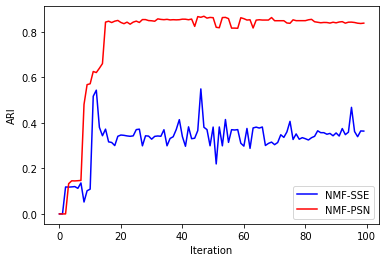

In [9]:
# compare NMF-SSE and NMF-Poisson
fig, ax = plt.subplots()
nmf_sse_perf_df = pd.DataFrame(data=nmf_sse_perf, columns=['Iter', "SSE", 'ARI'])
nmf_psn_perf_df = pd.DataFrame(data=nmf_psn_perf, columns=['Iter', "Poisson", 'ARI'])
ax.plot(nmf_sse_perf_df["Iter"], nmf_sse_perf_df["ARI"], color='blue', label='NMF-SSE')
ax.plot(nmf_psn_perf_df["Iter"], nmf_psn_perf_df["ARI"], color='red', label='NMF-PSN')
ax.legend()
plt.xlabel("Iteration")
plt.ylabel("ARI")
plt.savefig("figures/nmf_sse_vs_psn.eps")

## Model initialization and helper methods for q4 to q8

In [10]:
# Q4-Q7 VAE single-cell embedded topic model
X_tensor = torch.from_numpy(np.array(X, dtype="float32"))
sums = X_tensor.sum(1).unsqueeze(1)
X_tensor_normalized = X_tensor / sums

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ETM(num_topics=K,
            vocab_size=len(genes),
            t_hidden_size=256,
            rho_size=256,
            theta_act='relu',
            embeddings=None,
            train_embeddings=True,
            enc_drop=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1.2e-6)


# train the VAE for one epoch
def train_scETM_helper(model, X_tensor, X_tensor_normalized):
    # initialize the model and loss
    model.train()
    optimizer.zero_grad()
    model.zero_grad()

    # forward and backward pass
    nll, kl_theta = model(X_tensor, X_tensor_normalized)
    loss = nll + kl_theta
    loss.backward()  # backprop gradients w.r.t. negative ELBO

    # clip gradients to 2.0 if it gets too large
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

    # update model to minimize negative ELBO
    optimizer.step()

    return torch.sum(loss).item()


# get sample encoding mp_anndata from the trained encoder network
def get_theta(model, input_x):
    model.eval()
    with torch.no_grad():
        q_theta = model.q_theta(input_x)
        mu_theta = model.mu_q_theta(q_theta)
        theta = F.softmax(mu_theta, dim=-1)
        return theta

## Question 4

0
100
200
300
400
500
600
700
800
900


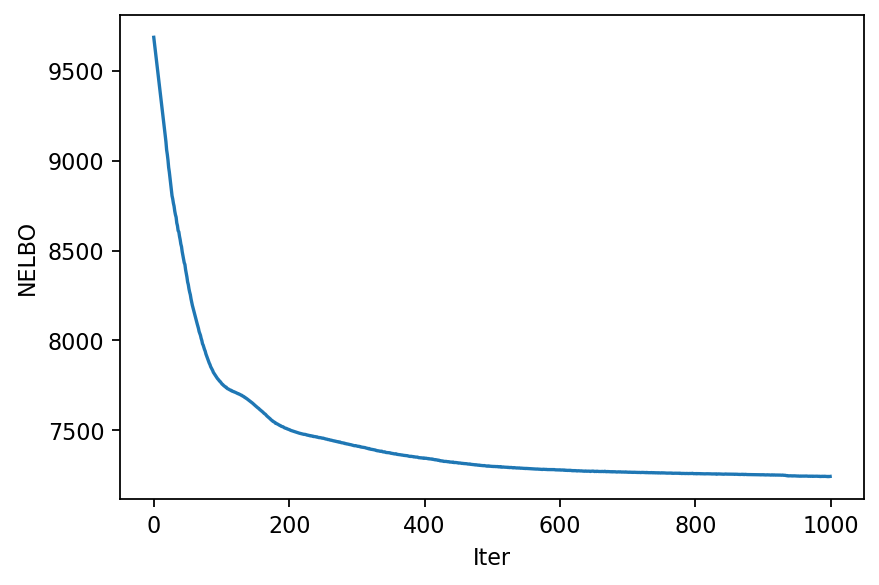

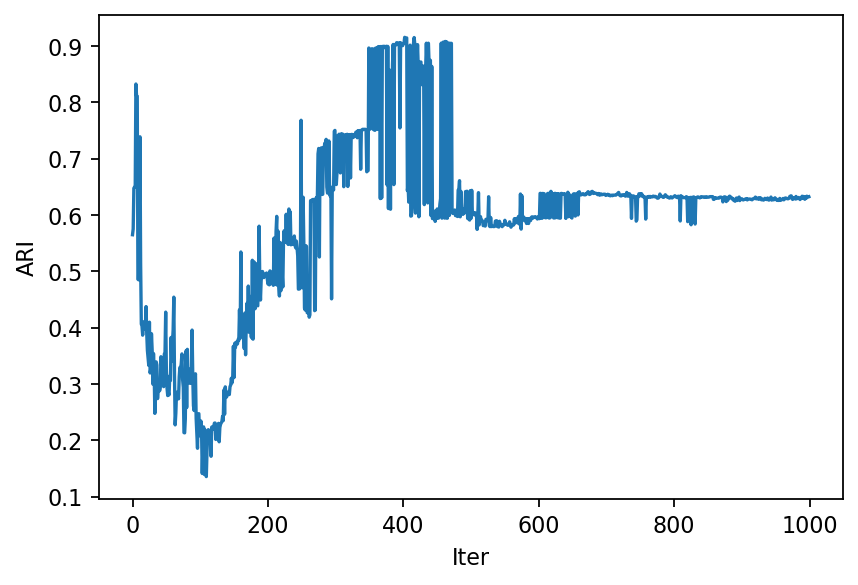

In [11]:
######## Q4 complete this function #######
def train_scETM(model, X_tensor, X_tensor_normalized, adata=mp_anndata, niter=1000):
    """
        :param model: the scETM model object
        :param X_tensor: NxM raw read count matrix X
        :param X_tensor_normalized: NxM normalized read count matrix X
        :param adata: annotated single-cell data object with ground-truth cell type information for evaluation
        :param niter: maximum number of epochs
        :return:
            1. model: trained scETM model object
            2. perf: niter-by-3 ndarray with iteration index, SSE, and ARI as the 3 columns
    """
    perf = np.ndarray(shape=(niter, 3), dtype='float')

    # WRITE YOUR CODE HERE
    loss = []
    ari = []
    for n in range(niter):
        if (n%100 == 0):
            print(n)
        loss = train_scETM_helper(model, X_tensor, X_tensor_normalized)
        theta = get_theta(model, X_tensor_normalized)
        ari = evaluate_ari(theta, adata)
        perf[n] = [n, loss, ari]
    return model, perf

model, scetm_perf = train_scETM(model, X_tensor, X_tensor_normalized)
monitor_perf(scetm_perf, "NELBO", 'figures/scETM_train.eps')
monitor_perf(scetm_perf, "ARI", 'figures/scETM_ari.eps')

## Question 5

0


/var/folders/x4/8fjj83rx5hd3kmp8042m26840000gn/T/ipykernel_43784/1396655159.py:37: RuntimeWarning: divide by zero encountered in true_divide
  mse = cal_log(X, cur_W, cur_H) / (m * n)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


100
200
300
400
500
600
700
800
900


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


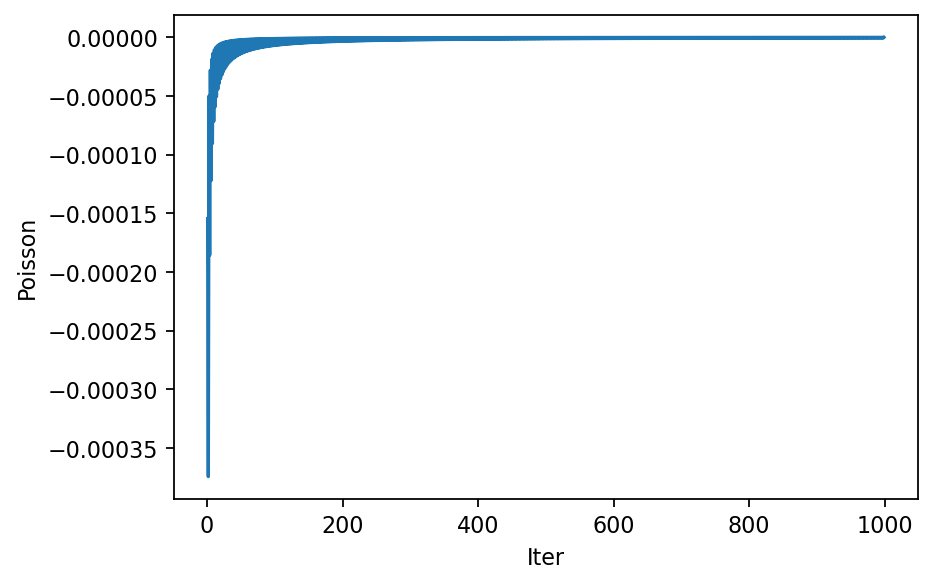

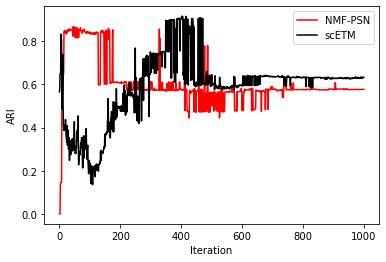

In [12]:
# Compare NMF-Poisson and scETM
W_nmf_psn, H_nmf_psn, nmf_psn_perf = nmf_psn(X.T, W_init, H_init, niter=1000)
monitor_perf(nmf_psn_perf, "Poisson", 'figures/nmf_psn_1000.eps')

_, ax = plt.subplots()
nmf_psn_perf_df = pd.DataFrame(data=nmf_psn_perf, columns=['Iter', "Poisson", 'ARI'])
scetm_perf_df = pd.DataFrame(data=scetm_perf, columns=['Iter', "NELBO", 'ARI'])
ax.plot(nmf_psn_perf_df["Iter"], nmf_psn_perf_df["ARI"], color='red', label='NMF-PSN')
ax.plot(scetm_perf_df["Iter"], scetm_perf_df["ARI"], color='black', label='scETM')
plt.xlabel("Iteration");
plt.ylabel("ARI")
ax.legend()
plt.savefig("figures/nmf_vs_scetm.eps")

## Question 6

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


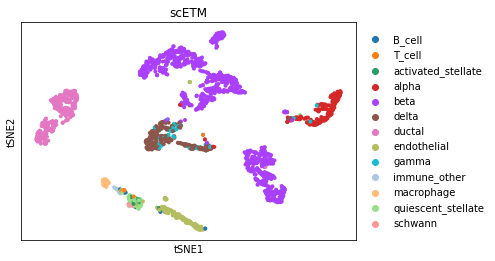

<Figure size 432x288 with 0 Axes>

In [13]:
theta = get_theta(model, X_tensor_normalized)
theta_np = theta.numpy() 
theta_ann = anndata.AnnData(theta_np, dtype=theta_np.dtype)
theta_ann.obs['cell_type'] = sample_info['assigned_cluster'].values
sc.tl.tsne(theta_ann)
sc.pl.tsne(theta_ann, color='cell_type', title = 'scETM')
plt.savefig('figures/tsne_scETM.png')

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


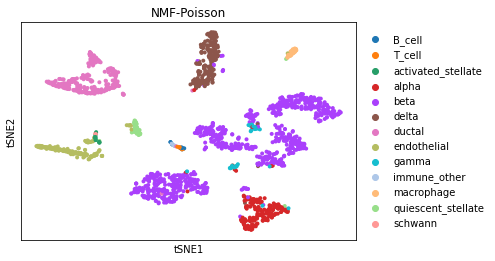

<Figure size 432x288 with 0 Axes>

In [14]:
psn_ann = anndata.AnnData(H_nmf_psn.T, dtype=H_nmf_psn.dtype)
psn_ann.obs['sample'] = sample_info['assigned_cluster'].values
sc.tl.tsne(psn_ann)
sc.pl.tsne(psn_ann, color='sample', title = 'NMF-Poisson')
plt.savefig('figures/tsne_NMF.png')

## Question 7

/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


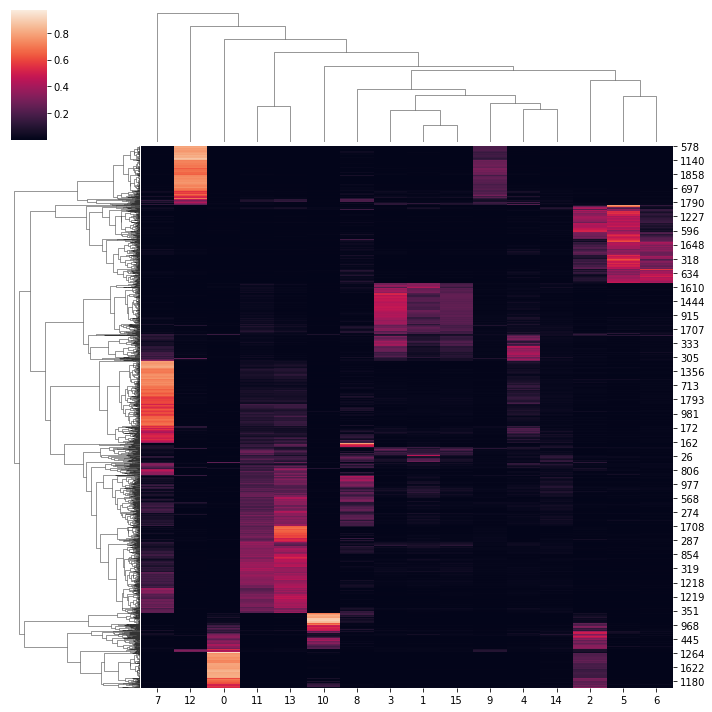

In [15]:
clustermap(theta)
plt.savefig('figures/cells_heatmap_scetm.png')

## Question 8

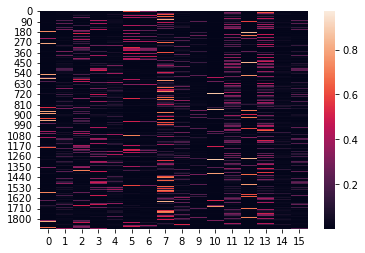

In [16]:
heatmap(theta)
plt.savefig('figures/topics_heatmap_scetm.png')

Please note: The following observatation from heatmap with no cap. We can see the lot of gene in each most topics have high probability. For topic, not many genes have shown high probability, for topics 7, 11 and 13, lot of genes have shown high probability. 